Домашнее задание по глубокому обучению №1
Студент: Самаковский Вячеслав

### Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
from IPython.display import clear_output

Проверим, доступна ли GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Загрузка датасета

In [7]:
train_csv = pd.read_csv("/content/fashion-mnist_train.csv")
test_csv = pd.read_csv("/content/fashion-mnist_test.csv")

In [8]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


Класс для создания датасетов из датафреймов

In [9]:
class FashionDataset(Dataset):
    """Класс для создания датасетов из датафреймов."""

    def __init__(self, data, transform = None):
        self.fashion_MNIST = list(data.values)
        self.transform = transform

        label = []
        image = []

        for i in self.fashion_MNIST:
             # Первый столбец это лейбл изображения.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Переведем изображение в формат 28х28х1
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

Преобразуем датафреймы в тензоры с помощью DataLoader

In [10]:
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

### Функция для обучения

In [11]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=25, device='cuda'):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Обучение
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # Валидация
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects / len(test_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)
        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # Графики
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(val_loss_history, label='Test Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_acc_history, label='Train Accuracy')
        plt.plot(val_acc_history, label='Test Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(train_loss_history[-1], train_acc_history[-1]))
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return model

### Простая сверточная сеть

Поскольку работаем с изображениями есть смысл сразу работать со сверточными нейросетями. Начнем с простого, будет один сверточный слой и два полносвязных. Использовать softmax в конце не имеет смысла, посколько используем Кросс Энтропию.

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Сверточные слои
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # 32 -> 16 каналов
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=16*14*14, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

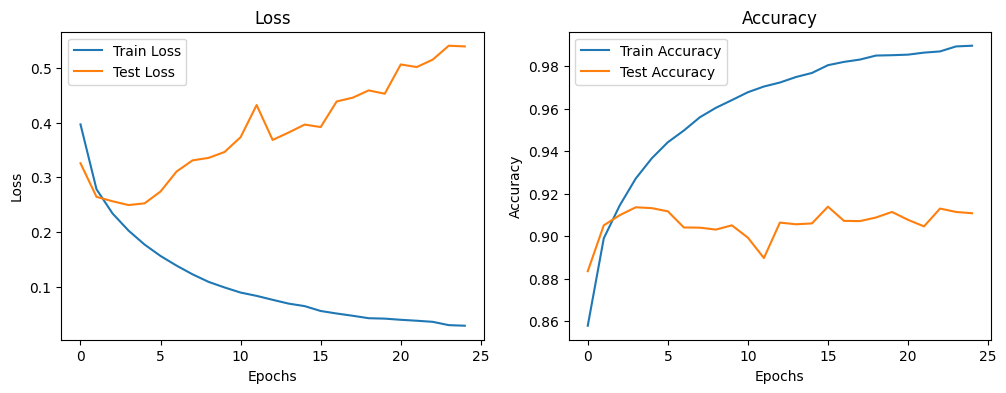

Train Loss: 0.0286 Acc: 0.9897
Validation Loss: 0.5391 Acc: 0.9108


In [ ]:
model = SimpleCNN()
model.to(device)

num_epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Не смотря на хорошее значение точности, по графикам отчетливо видно переобучение. Попробуем уменьшить шаг обучения.

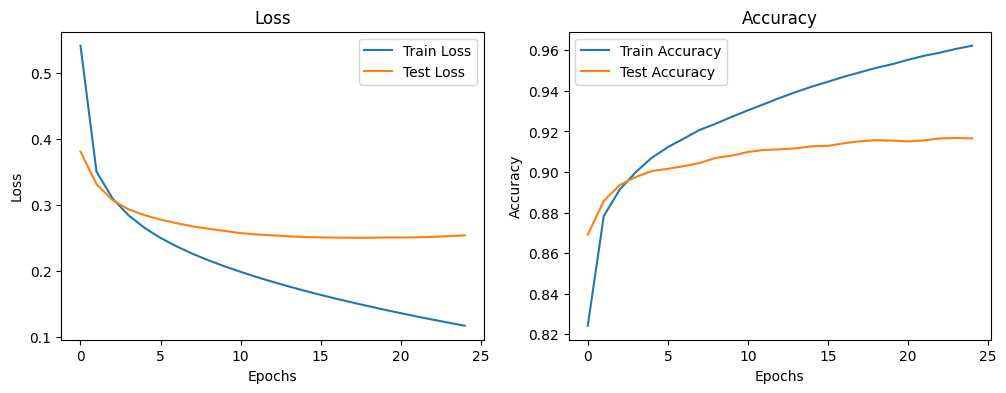

Train Loss: 0.1166 Acc: 0.9623
Validation Loss: 0.2535 Acc: 0.9166


In [ ]:
model = SimpleCNN()
model.to(device)

num_epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Переобучение намного меньше, но результат все еще далек от идеала. Попробуем усложнить модель и добавить слоев.

### Более глубокая сеть

In [ ]:
class ImprovedSimpleCNN(nn.Module):

    def __init__(self):
        super(ImprovedSimpleCNN, self).__init__()

        # Первый сверточный слой
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Второй сверточный слой
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Третий сверточный слой
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=128*3*3, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

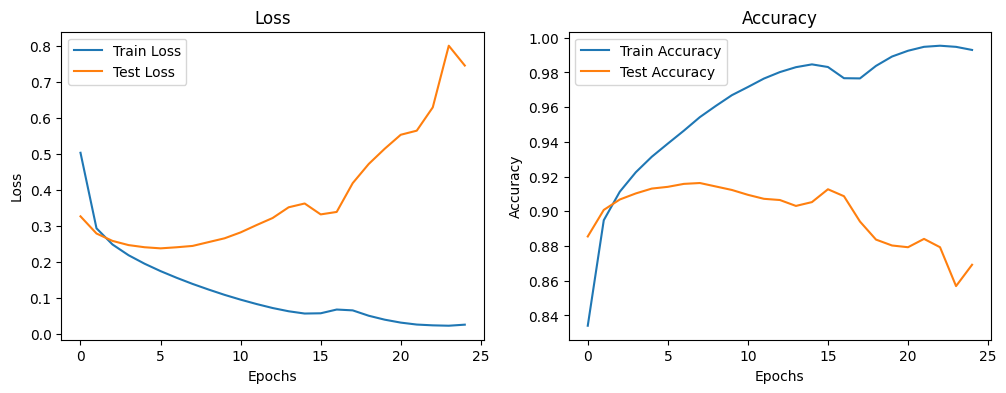

Train Loss: 0.0254 Acc: 0.9930
Validation Loss: 0.7455 Acc: 0.8692


In [ ]:
model = ImprovedSimpleCNN()
model.to(device)

num_epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Модель сильно переобучается, попробуем поставить ограничения в виде дропаута.

### Модель с dropout

In [ ]:
class DropoutSimpleCNN(nn.Module):

    def __init__(self):
        super(DropoutSimpleCNN, self).__init__()

        # Первый сверточный слой
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Второй сверточный слой
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Третий сверточный слой
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=128*3*3, out_features=256)
        self.drop = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = self.fc2(out)

        return out

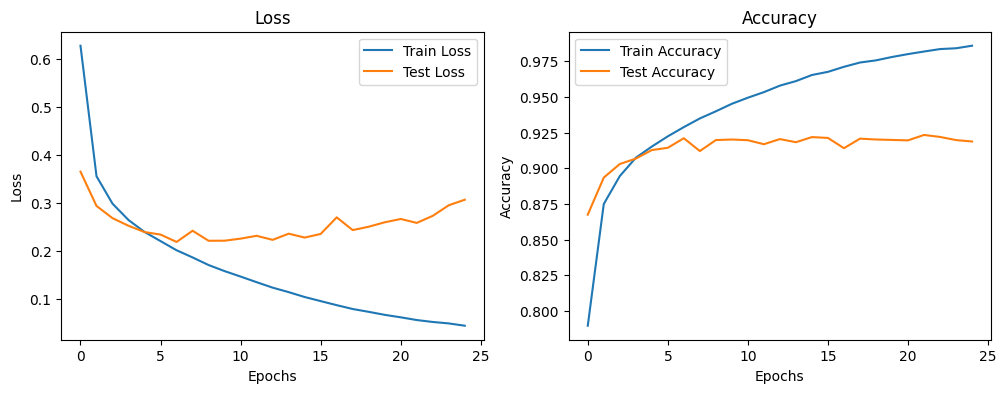

Train Loss: 0.0433 Acc: 0.9860
Validation Loss: 0.3059 Acc: 0.9188


In [ ]:
model = DropoutSimpleCNN()
model.to(device)

num_epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Попробывал дропауты 0.25, 0.5, 0.75. Каждый из них давал примерно одинаковый результат. Лучше чем без дропаута, но его значение не сильно влияет на итог. Попробуем добавить к дропауту еще и L2 регуляризацию

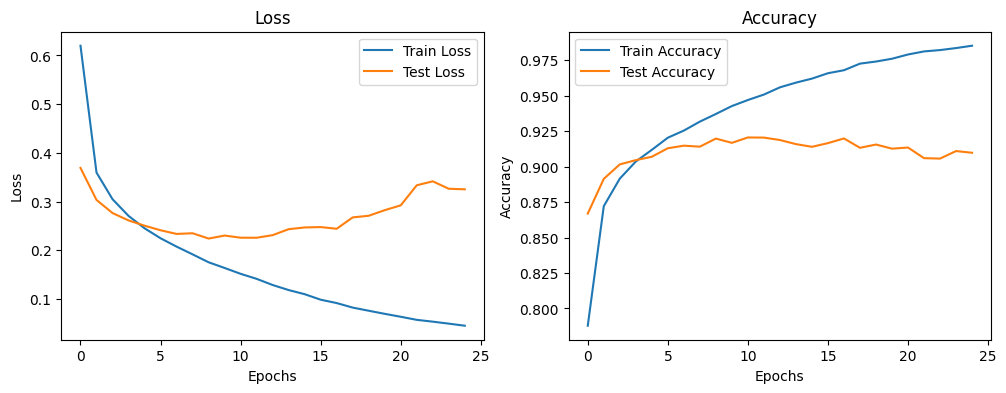

Train Loss: 0.0452 Acc: 0.9853
Validation Loss: 0.3252 Acc: 0.9098


In [ ]:
model = DropoutSimpleCNN()
model.to(device)

num_epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Регуляризация не принесла результата. Попробем добавить еще один дропаут.

In [ ]:
class Dropout2SimpleCNN(nn.Module):

    def __init__(self):
        super(Dropout2SimpleCNN, self).__init__()

        # Первый сверточный слой
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Второй сверточный слой
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Третий сверточный слой
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=128*3*3, out_features=256)
        self.drop = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = self.fc2(out)
        out = self.drop(out)

        return out

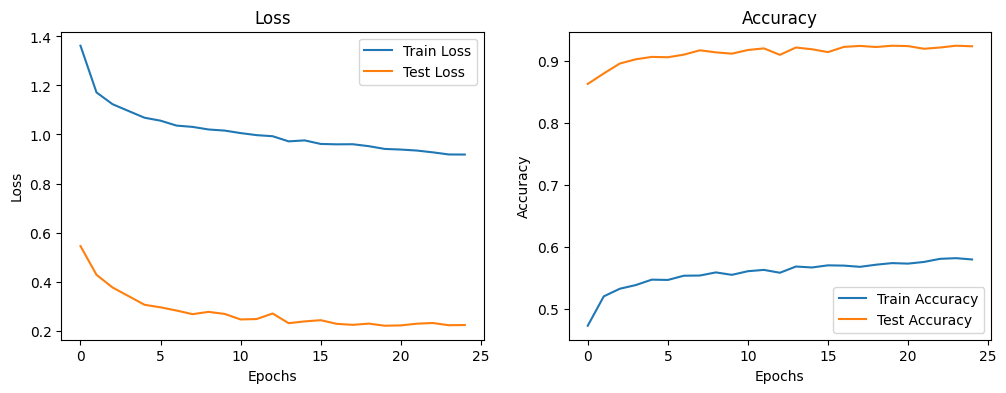

Train Loss: 0.9182 Acc: 0.5801
Validation Loss: 0.2230 Acc: 0.9237


In [ ]:
model = Dropout2SimpleCNN()
model.to(device)

num_epochs=25
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Значения явно лучше. Нет видимого переобучения. Попробуем увеличить количество эпох

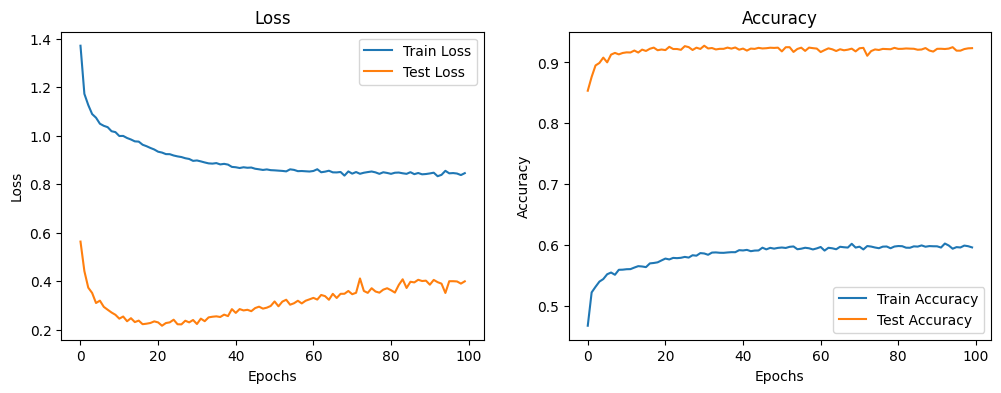

Train Loss: 0.8458 Acc: 0.5963
Validation Loss: 0.3997 Acc: 0.9235


In [ ]:
model = Dropout2SimpleCNN()
model.to(device)

num_epochs=100
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

После 20й эпохи лосс все равно начинает расти. Попробуем сделать сеть более глубокой.

In [15]:
class DeepCNN(nn.Module):

    def __init__(self):
        super(DeepCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.25)
        )

        self.fc1 = nn.Linear(in_features=128*7*7, out_features=512)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.drop(out)
        out = self.fc3(out)

        return out

In [14]:
model = DeepCNN()
test_tensor = torch.rand(1, 1, 28, 28)
with torch.no_grad():  # Убедимся, что мы не требуем градиенты
    out = model.layer1(test_tensor)
    out = model.layer2(out)
    out = model.layer3(out)

print(out.shape)


torch.Size([1, 128, 7, 7])
in_features: 6272


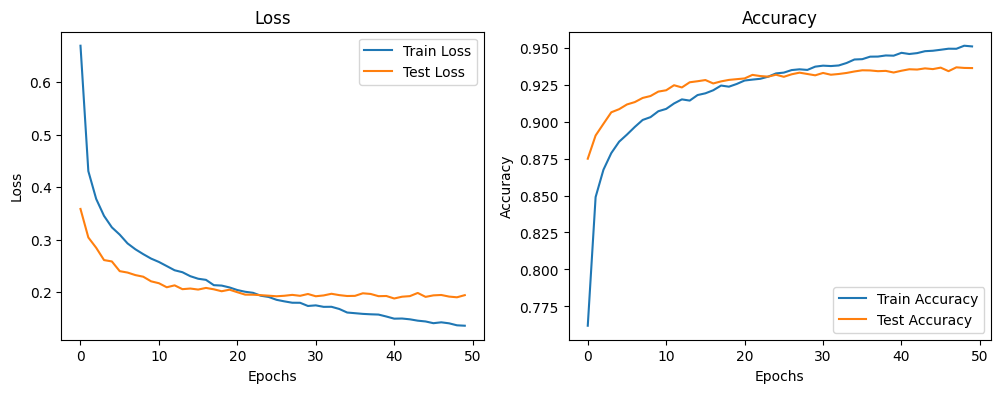

Train Loss: 0.1362 Acc: 0.9509
Validation Loss: 0.1943 Acc: 0.9362


In [20]:
model = DeepCNN()
model.to(device)

num_epochs=50
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

### Загрузка результата

In [21]:

model.eval()  # Устанавливаем модель в режим оценки
predictions = []

with torch.no_grad():  # Отключаем вычисление градиентов
        for batch in test_loader:
            inputs = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

# Загрузка шаблона для отправки и запись предсказаний
submission = pd.read_csv('/content/sample_submission.csv', index_col=False)
submission['Category'] = predictions
submission.to_csv('/content/sample_submission2.csv', index=False)
